# Developing functions for computing the FFDI drought factor via the KBDI

In [1]:
import xarray as xr

import numpy as np

from src.prepare_data import _open

import matplotlib.pyplot as plt

In [2]:
%load_ext lab_black

## Cluster

In [3]:
from distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-q express",
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    header_skip=["select"],
)

cluster.scale(jobs=1)
client = Client(cluster)
print(f"Dask daskboard link: {client.dashboard_link}")

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Dask daskboard link: http://10.6.41.58:8787/status


## Develop on some AGCD data

In [3]:
prep_data = False

if prep_data:
    agcd = _open.AGCD(["precip", "tmax"], None, None)

    precip = agcd[["precip"]].sel(time=slice("2005", None)).chunk({"time": -1})
    precip.to_zarr("agcd_precip.zarr", mode="w")

    tmax = agcd[["tmax"]].sel(time=slice("2005", None)).chunk({"time": -1})
    tmax.to_zarr("agcd_tmax.zarr", mode="w")

precip = xr.open_zarr("agcd_precip.zarr")
tmax = xr.open_zarr("agcd_tmax.zarr")

In [25]:
Mangalore = {"lon": 145.2, "lat": -36.9}

precip_test = (
    precip["precip"]
    .sel(Mangalore, method="nearest")
    .sel(time=slice("2010", "2014"))
    .values
)
tmax_test = (
    tmax["tmax"].sel(Mangalore, method="nearest").sel(time=slice("2010", "2014")).values
)
precip_annual_test = (
    precip["precip"]
    .sel(Mangalore, method="nearest")
    .sel(time=slice("2010", "2014"))
    .resample(time="A")
    .sum()
    .mean("time")
    .values
)

In [26]:
def calculate_Peff(precip, remaining_runoff):
    """
    Return Peff term in the KBDI and the remaining runoff from the daily
    rainfall
    """
    runoff_amount = 5
    if remaining_runoff is None:
        runoff = np.where(precip < runoff_amount, precip, runoff_amount)
        Peff = precip - runoff
        remaining_runoff = runoff_amount
    else:
        remaining_runoff = np.where(precip > 0, remaining_runoff, runoff_amount)
        runoff = np.where(precip < remaining_runoff, precip, remaining_runoff)
        Peff = precip - runoff
    return Peff, remaining_runoff - runoff


def calculate_ET(KBDI_prev, tmax_prev, precip_annual):
    """
    Return evapotransporation (ET) term in the KBDI
    """
    term_1 = 203.2 - KBDI_prev
    term_2 = 0.968 * np.exp(0.0875 * tmax_prev + 1.5552) - 8.3
    term_3 = 1 + 10.88 * np.exp(-0.00173 * np.expand_dims(precip_annual, -1))
    return 1e-3 * term_1 * term_2 / term_3


def _calculate_KBDI_block(
    precip, tmax, precip_annual, KBDI_prev, tmax_prev, remaining_runoff
):
    """
    Returns the KBDI for a block of data
    """
    KBDI = np.zeros_like(precip)

    Peff, remaining_runoff = calculate_Peff(precip[..., 0], remaining_runoff)
    if KBDI_prev is not None:
        ET = calculate_ET(KBDI_prev, tmax_prev, precip_annual)
        KBDI[..., 0] = KDBI_prev - Peff + ET

    for i in range(1, KBDI.shape[-1]):
        Peff, remaining_runoff = calculate_Peff(precip[..., i], remaining_runoff)
        ET = calculate_ET(KBDI[..., i - 1], tmax[..., i - 1], precip_annual)
        KBDI_curr = KBDI[..., i - 1] - Peff + ET
        KBDI[..., i] = np.where(KBDI_curr < 0, 0, KBDI_curr)

    return KBDI

In [27]:
KBDI = _calculate_KBDI_block(
    precip_test, tmax_test, precip_annual_test, None, None, None
)

(0.0, 200.0)

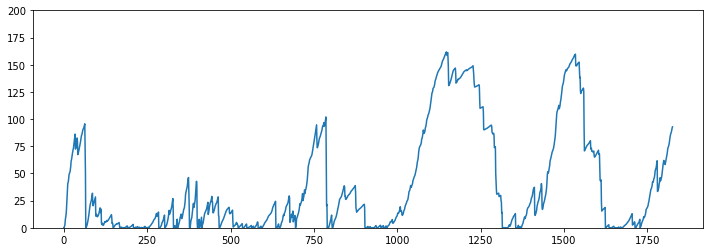

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(KBDI)
plt.ylim(0, 200)

In [381]:
precip_test[120:130]

array([0.01855469, 0.0234375 , 0.        , 0.        , 6.741211  ,
       0.15039062, 0.07617188, 0.88378906, 0.0390625 , 0.13378906],
      dtype=float32)

In [382]:
Peff[120:130]

array([0.01855469, 0.0234375 , 0.        , 0.        , 1.7412109 ,
       0.15039062, 0.07617188, 0.88378906, 0.0390625 , 0.13378906],
      dtype=float32)

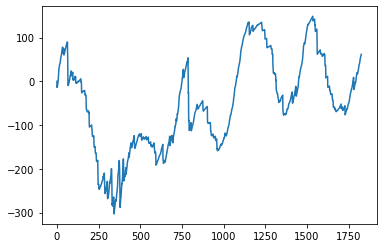

In [369]:
plt.plot(KBDI)

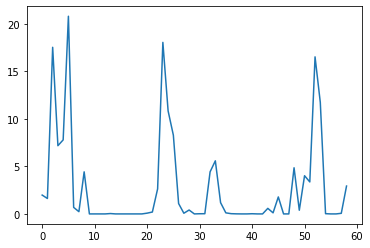

In [297]:
plt.plot(precip[41:100])

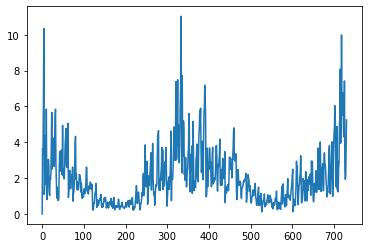

In [243]:
plt.plot(ET)

## Calculate KBDI

In [156]:
def calculate_KBDI(precip, tmax, precip_annual):
    def _calculate_KBDI(precip, tmax, precip_annual):
        """
        Calculate the Keetch-Byram drought index, defined as:

            KBDI_n = KBDI_n-1 − Peff + ET

        Peff is the daily rainfall, precip, decreased by an amount to allow for interception
        and/or runoff:

            Peff = precip_n - (interception/runoff)

        where the interception and/or runoff is approximated as the first 5 mm within consecutive
        days with nonzero rainfall.

        ET is the evapotransporation, estimated as:

            ET = (203.2 - KBDI_n-1) * (0.968 * exp(0.0875 * tmax_n-1 + 1.5552) - 8.3)
                 -------------------------------------------------------------------- * 10 ** (-3)
                              1 + 10.88 * exp(-0.00173 * precip_annual)

        where tmax is the daily max temperature and precip_annual is the mean annual rainfall

        Parameters
        ----------
        precip : numpy array with shape [..., N]
            Array of daily precipitation with the last axes corresponding to the time dimension
        tmax : numpy array with shape [..., N]
            Array of max daily temperature with the last axes corresponding to the time dimension
        precip_annual : numpy array with shape [...]
            Array containing the mean annual rainfall. Usually this is computed as the average over
            a period of years corresponding the calculation period of the KBDI

        References
        ----------
        Finkele et al. 2006 (on calculation):
            https://webarchive.nla.gov.au/awa/20060903105143/http://www.bom.gov.au/bmrc/pubs/researchreports/RR119.pdf
        Holgate et al. 2017 (on calculation):
            https://www.publish.csiro.au/wf/WF16217
        Dolling et al. 2005 (on initialisation):
            https://www.sciencedirect.com/science/article/pii/S0168192305001802#bib5
        """

        def calculate_Peff(precip, remaining_runoff):
            """
            Return Peff term in the KBDI and the remaining runoff from the daily
            rainfall and leftover remaining runoff
            """
            runoff_amount = 5
            if remaining_runoff is None:
                runoff = np.where(precip < runoff_amount, precip, runoff_amount)
                Peff = precip - runoff
                remaining_runoff = runoff_amount - runoff
            else:
                remaining_runoff = np.where(precip > 0, remaining_runoff, runoff_amount)
                runoff = np.where(precip < remaining_runoff, precip, remaining_runoff)
                Peff = precip - runoff
            return Peff, remaining_runoff - runoff

        def calculate_ET(KBDI_prev, tmax_prev, precip_annual):
            """
            Return evapotransporation (ET) term in the KBDI
            """
            term_1 = 203.2 - KBDI_prev
            term_2 = 0.968 * np.exp(0.0875 * tmax_prev + 1.5552) - 8.3
            term_3 = 1 + 10.88 * np.exp(-0.00173 * np.expand_dims(precip_annual, -1))
            return 1e-3 * term_1 * term_2 / term_3

        def _calculate_KBDI_block(
            precip, tmax, precip_annual, KBDI_prev, tmax_prev, remaining_runoff
        ):
            """
            Returns the KBDI for a block of data
            """
            KBDI = numpy.zeros_like(block)

            if KBDI_prev is not None:
                Peff, remaining_runoff = calculate_Peff(
                    precip[..., 0], remaining_runoff
                )
                ET = calculate_ET(KBDI_prev, tmax_prev, precip_annual)
                KBDI[..., 0] = KDBI_prev - Peff + ET

            for i in range(1, block.shape[-1]):
                Peff, remaining_runoff = calculate_Peff(precip[..., i], remaining_runoff)
                ET = calculate_ET(KBDI[..., i-1], tmax[..., i-1], precip_annual)
                KBDI[...,i] = KBDI[..., i-1] - Peff + ET

            return KBDI

        for block in precip.data.blocks:
            api = dask.array.map_blocks(
                api_block, block, prev, meta=numpy.array((), dtype=block.dtype)
            )
            prev = api[-1, :, :]

            api_blocks.append(api)

    return xr.apply_ufunc(
        _calculate_KBDI,
        precip,
        tmax,
        precip_annual,
        input_core_dims=[["time"], ["time"], []],
        dask="allowed",
    )

In [68]:
calculate_KBDI(precip["precip"], tmax["tmax"], precip_annual["precip"])

dask.array<transpose, shape=(691, 886, 731), dtype=float32, chunksize=(40, 40, 731), chunktype=numpy.ndarray>


ValueError: applied function returned data with unexpected number of dimensions. Received 0 dimension(s) but expected 2 dimensions with names: ('lat', 'lon')